In [1]:
# %matplotlib widget

import sys
sys.path.append("./../scripts")
import PandemiXFunctions as pf
import PandemiXModelFunctions as pmf

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.facecolor'] = (1,1,1,1)
plt.rcParams["image.cmap"] = "tab10"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fs_label = 16
parameters = {
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.markersize': 10,
                'lines.linewidth': 3
             }
plt.rcParams.update(parameters)

import datetime
             
from scipy.integrate import cumtrapz
# int_I = cumtrapz(np.exp(u_H*ts)*Is,ts, initial=0)
# Hs = np.exp(-u_H*ts) * (r_chr*pars_full['gamma']*int_I + k) 

In [2]:
# Model with explicit symptomatic category and keeping track of whether recovered were found or not
modelMeta = ({
     'beta * S * (P+A)' : ['S','E1'],
     'gamma * E1' : ['E1','E2'],
     'gamma * E2' : ['E2','P'],
     'gamma * rho * P' : ['P','I'],
     'gamma * (1-rho) * P' : ['P','A'],
     'nu * A' : ['A',None],
     'nu * Q' : ['Q','Rp'],
     # 'nu * I' : ['I',None],
     'nu * I' : ['I','Rp'], # Assuming that symptomatic cases get tested, but aren't included in Q 
     'tau * E2' : ['E2','Q'],
     'tau * P'  : ['P','Q'],
     'tau * A'  : ['A','Q'],
     # 'tau * I'  : ['I','Q'], # Testing of symptomatic cases
     # 'tauInf * I'  : ['I','Q'], # Testing of symptomatic cases
     
},
['S','E1','E2','P','A','Q','I','Rp'],['beta','gamma','nu','rho','tau'])


In [3]:

DKpop = 5800000

In [4]:
# Define paths
rootdir_data = os.getcwd() +"/../DanskeData/" 

path_data = rootdir_data + "ssi_data/"
path_dash = rootdir_data + "ssi_dashboard/"
path_vacc = rootdir_data + "ssi_vacc/"

path_figs = os.getcwd() +"/../Figures/" 

In [5]:

latestsubdir = list(os.walk(path_dash))[0][1][-1]
latestdir = path_dash + latestsubdir

dfReinfFile = pd.read_csv(latestdir+'/Regionalt_DB/24_reinfektioner_daglig_region.csv',encoding='latin1',delimiter = ';')
dfReinfFile['Prøvedato'] = pd.to_datetime(dfReinfFile['Prøvedato'])
# groupdf = df.groupby(['Prøvedato').sum()
# df_reinf = dfReinfFile[dfReinfFile['Type af tilfælde (reinfektion eller bekræftet tilfælde)'] == '1.Reinfektion'].groupby('Prøvedato').sum()
# df_inf = dfReinfFile[dfReinfFile['Type af tilfælde (reinfektion eller bekræftet tilfælde)'] != '1.Reinfektion'].groupby('Prøvedato').sum()
df_reinf = dfReinfFile[dfReinfFile['Type af tilfælde (reinfektion eller første infektion)'] == '1.Reinfektion'].groupby('Prøvedato').sum()
df_inf = dfReinfFile[dfReinfFile['Type af tilfælde (reinfektion eller første infektion)'] != '1.Reinfektion'].groupby('Prøvedato').sum()


In [6]:
# Although the data is not entirely complete (or trustworthy), Test_pos_over_time.csv and Test_pos_over_time_antigen.csv are deemed to be accurate enough for modelling purposes 


latestsubdirs_data = np.sort(list(os.walk(path_data))[0][1])[-1]

latestdir_data = path_data + latestsubdirs_data
dfTest = pd.read_csv(latestdir_data+'/Test_pos_over_time.csv',encoding='latin1',delimiter=';',dtype=str)
dfTestAG = pd.read_csv(latestdir_data+'/Test_pos_over_time_antigen.csv',encoding='latin1',delimiter=';',dtype=str)


dfTest = dfTest.iloc[:-2]
dfTestAG = dfTestAG.iloc[:-2]

dfTest['Date'] = pd.to_datetime(dfTest['Date'])
dfTestAG['Date'] = pd.to_datetime(dfTestAG['Date'])

dfTest['Tested_kumulativ'] = pd.to_numeric(dfTest['Tested_kumulativ'].str.replace('.',''))
dfTestAG['Tested_kumulativ'] = pd.to_numeric(dfTestAG['Tested_kumulativ'].str.replace('.',''))

C:\Users\Rasmus\AppData\Local\Temp/ipykernel_2568/839705210.py:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dfTest['Tested_kumulativ'] = pd.to_numeric(dfTest['Tested_kumulativ'].str.replace('.',''))
C:\Users\Rasmus\AppData\Local\Temp/ipykernel_2568/839705210.py:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dfTestAG['Tested_kumulativ'] = pd.to_numeric(dfTestAG['Tested_kumulativ'].str.replace('.',''))


In [7]:
firstDate = np.datetime64('2021-11-29')

# daysToUse = firstDate + [np.timedelta64(x,'D') for x in np.arange(-10,400)]
daysToUse = firstDate + [np.timedelta64(x*7,'D') for x in np.arange(-10,40)]
daysToUse

dfTestWeek = dfTest[dfTest.Date.isin(daysToUse)]
dfTestAGWeek = dfTestAG[dfTestAG.Date.isin(daysToUse)]

testPCR = dfTestWeek['Tested_kumulativ'].diff().values
testAG = dfTestAGWeek['Tested_kumulativ'].diff().values

testTot = testPCR + testAG 
testTotScaled = testPCR + 0.5*testAG 



In [8]:
# df_inf_week = df_inf[df_inf]
totInfDays = df_inf.index 
totInf = df_inf.infected+df_reinf.infected

totInfCumu = totInf.cumsum()
totInfWeek = totInfCumu[totInfCumu.index.isin(daysToUse)]

infWeek = totInfWeek.diff()

# infWeek

In [9]:

dataDates = infWeek.index[1:]
infWeek = infWeek[1:]
testTot = testTot[1:]
testTotScaled = testTotScaled[1:]
testPCR = testPCR[1:]
testAG= testAG[1:]

In [10]:
# fig,(ax,ax2) = plt.subplots(2,1)
# ax.step(dataDates,testPCR,where='pre')
# ax.step(dataDates,testAG,where='pre')
# ax.step(dataDates,testTotScaled,where='pre')
# ax.step(dataDates,infWeek,where='pre')

# ax2.step(dataDates,100*infWeek/testTotScaled,where='pre')

# ax.set_ylim(bottom=0)
# ax2.set_ylim(bottom=0)

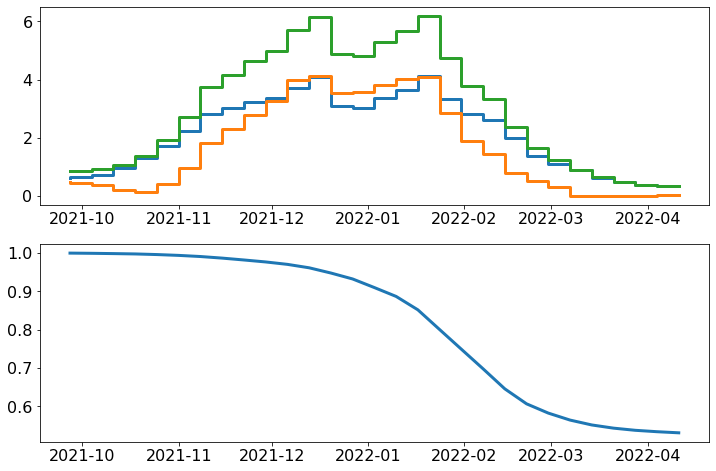

In [27]:
fig,(ax,ax2) = plt.subplots(2,1)
ax.step(dataDates,100*testPCR/(DKpop*7),where='pre')
ax.step(dataDates,100*testAG/(DKpop*7),where='pre')
ax.step(dataDates,100*testTotScaled/(DKpop*7),where='pre')

prevInf = 100*np.cumsum(infWeek)/(DKpop)
# ax2.plot(dataDates,prevInf)
ax2.plot(dataDates,0.01*(100-prevInf))



# ax2.step(dataDates,100*infWeek/testTotScaled,where='pre')

# ax.set_ylim(bottom=0)
# ax2.set_ylim(bottom=0)

# ax.set_ylabel('Average daily share\nof population [%]')
# ax2.set_ylabel('Positive ratio [%]')

Text(0, 0.5, 'Positive ratio [%]')

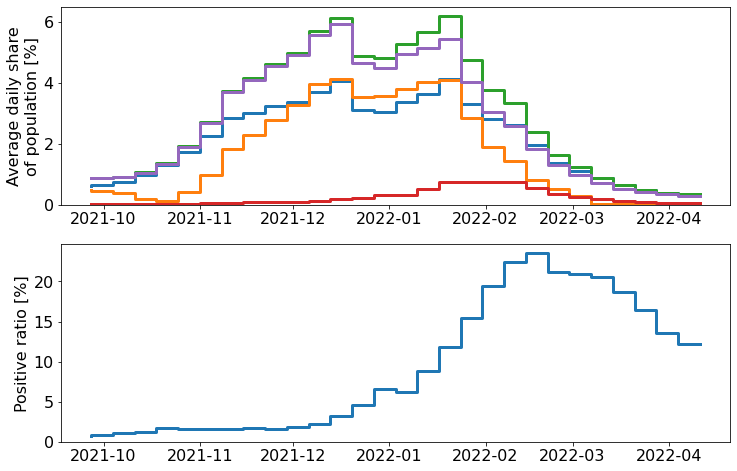

In [21]:
fig,(ax,ax2) = plt.subplots(2,1)
ax.step(dataDates,100*testPCR/(DKpop*7),where='pre')
ax.step(dataDates,100*testAG/(DKpop*7),where='pre')
ax.step(dataDates,100*testTotScaled/(DKpop*7),where='pre')
ax.step(dataDates,100*infWeek/(DKpop*7),where='pre')
ax.step(dataDates,100*(testTotScaled-infWeek)/(DKpop*7),where='pre')

ax2.step(dataDates,100*infWeek/testTotScaled,where='pre')

ax.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)

ax.set_ylabel('Average daily share\nof population [%]')
ax2.set_ylabel('Positive ratio [%]')

In [12]:
tausToUse = testTotScaled/(DKpop*7)
tausToUse

array([0.00870855, 0.00867073, 0.00920679, 0.01063398, 0.01364443,
       0.01933406, 0.02720972, 0.03751399, 0.04174218, 0.04633073,
       0.04995547, 0.05707417, 0.06146192, 0.04873985, 0.04825766,
       0.05288802, 0.05662333, 0.06192457, 0.04750181, 0.037712  ,
       0.03334395, 0.02374542, 0.01633405, 0.01245789, 0.00886388,
       0.00637367, 0.00490649, 0.00385518, 0.00338849])

In [13]:
numDays = (dataDates[-1] - dataDates[0])/np.timedelta64(1,'D')

numWeeksToSim = len(dataDates)

# Modelling

In [14]:

# allTRes = 100
# allTaus = tau * np.ones((allTRes,))
# allTaus = np.append(allTaus,tau *  2*np.ones((allTRes,)))

In [15]:
# Initialize everything
iniExp = 100
# iniExp = 1000

E1_0 = iniExp/DKpop 
E2_0 = 0
S_0 = 1 - E1_0 

init = {'S' : S_0,'E1':E1_0,'E2':0 , 'P':0,'A':0,'Q':0,'I':0,'Rp':0}

gamma = 1/3
nu = 1/3
rho = 0.5
beta = 1.65*gamma
# beta = 1.4*gamma
tau = tausToUse[0]
pars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}


tEnd = numDays
sch1 = pmf.Scheme(modelMeta,init,pars,0,tEnd,Changes=[])

allTRes = 100
allTaus = tau * np.ones((allTRes,))

for k in range(1,numWeeksToSim-1):
    tChange = k * 7
    tau = tausToUse[k]
    changeTest = pmf.Change(tChange,SetParameters={'tau':tau})
    sch1.addChange(changeTest)
    
    allTaus = np.append(allTaus,tau * np.ones((allTRes,)))


sch1.simulate(tRes=allTRes)

In [16]:
curSch = sch1 
curPop = DKpop
ts = curSch.result.t
Rp = curSch.result.Rp
Rn = 1-curSch.result.y.sum(axis=0)

curInf = gamma * rho * curSch.result.P
curTest = allTaus * (curSch.result.S + curSch.result.E1+ curSch.result.E2+ curSch.result.P + curSch.result.A )
curTestAll = allTaus * (curSch.result.S + curSch.result.E1+ curSch.result.E2+ curSch.result.P + curSch.result.A + Rn)

curTestPos = allTaus*( curSch.result.E2+ curSch.result.P + curSch.result.A )

posPct = (curTestPos+curInf)/(curTestAll+curInf)

In [17]:

# # fig,(ax,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(10,15))
# fig,(ax,ax2) = plt.subplots(2,1,figsize=(10,15))
# # ax.plot(ts,curTest)
# ax.plot(ts,curPop*(curTestAll))
# ax.plot(ts,curPop*(curTestPos))
# ax.plot(ts,curPop*(curTestAll+curInf))
# ax.plot(ts,curPop*(curInf+curTestPos))
# # ax.plot(ts,curInf*curPop)
# ax2.plot(ts,100*posPct)
# # ax2.plot(ts,100*(Rp/(Rp+Rn)))

In [18]:
# np.interp(dataDates,ts,ts)
modelDate = [dataDates[0]+np.timedelta64(int(x*24*60),'m') for x in ts]
# np.timedelta64(int(ts[1]*24),'h')

In [19]:
# # curRatioInterp = np.interp(np.arange(28),np.arange(2700),curRatio) 
# len(modelDate)
# len(dataDates)

C:\Users\Rasmus\AppData\Local\Temp/ipykernel_2568/110441614.py:2: RuntimeWarning: invalid value encountered in true_divide
  curRatio = Rp/(Rp+Rn)


ValueError: fp and xp are not of the same length.

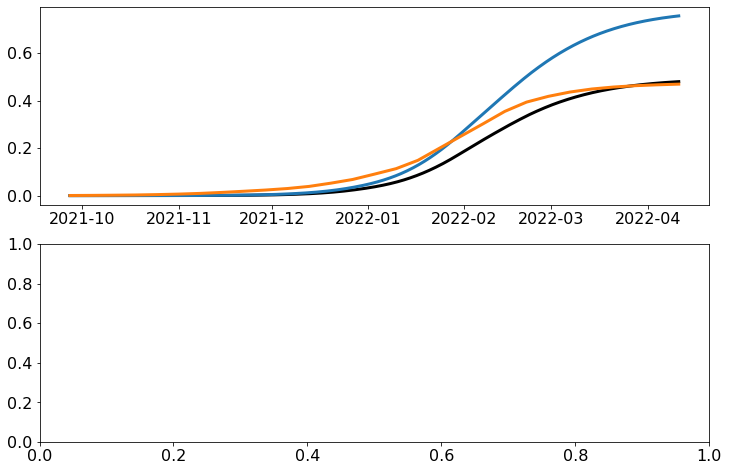

In [20]:
fig,(ax,ax2)= plt.subplots(2,1)
curRatio = Rp/(Rp+Rn)
ax.plot(modelDate,Rp,'k')
ax.plot(modelDate,Rp+Rn)
ax.plot(dataDates,np.cumsum(infWeek/(DKpop)))
curRatioInterp = np.interp(np.arange(28),np.arange(2700),curRatio) 
ax.plot(dataDates,np.cumsum(infWeek/(DKpop))/curRatioInterp,'r')
ax2.plot(modelDate,curRatio)

In [ ]:
fig,(ax,ax2) = plt.subplots(2,1)
# ax.plot(modelDate,100*(curTestAll))
# ax.plot(modelDate,100*(curTestPos))
ax.plot(modelDate,100*(curTestAll+curInf),'k')
ax.plot(modelDate,100*(curInf+curTestPos),'b')
# ax.plot(modelDate,curInf*curPop)
ax2.plot(modelDate,100*posPct)

ax.step(dataDates,100*testPCR/(DKpop*7),where='post')
ax.step(dataDates,100*testAG/(DKpop*7),where='post')
ax.step(dataDates,100*testTotScaled/(DKpop*7),where='post')
ax.step(dataDates,100*infWeek/(DKpop*7),where='post')

ax2.step(dataDates,100*infWeek/testTotScaled,where='post')

ax.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)

ax.set_ylabel('Average daily share\nof population [%]')
ax2.set_ylabel('Positive ratio [%]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'Positive ratio [%]')

In [ ]:
fig,ax1 = plt.subplots()
ts = sch1.result.t
ax1.plot(ts,allTaus)
ax1.plot(ts,sch1.result.Q)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:

# tChange = 150
# changeTest = pmf.Change(tChange,SetParameters={'tau':tau2,'beta':beta2})
# sch1.addChange(changeTest)
sch1.simulate(tRes=allTRes)

Rs = 1- sch1.result.y.sum(axis=0)

cmap = pf.getColormapFromList(['xkcd:dark blue','xkcd:blue','xkcd:red','xkcd:green','xkcd:dark green'],10)

fig,ax1 = plt.subplots()
ax1.stackplot(sch1.result.t,
        sch1.result.E1,
        sch1.result.E2,
        sch1.result.P,
        sch1.result.Q,
        sch1.result.A,
        sch1.result.I,
        sch1.result.Rp,
        Rs,
        sch1.result.S, 
        colors=[cmap(1),cmap(2),cmap(3),cmap(4),cmap(5),cmap(6),cmap(7),cmap(8),cmap(0)],
        )

ax1.set_ylim([0,1])
# # ax1.plot(sch1.result.t,sch1.result.E1)
# # ax1.plot(sch1.result.t,sch1.result.Rp)
# ax1.plot(sch1.result.t,sch1.result.Rp+Rs)
# ax1.plot(sch1.result.t,sch1.result.S)
# ax1.plot(sch1.result.t,sch1.result.Q)
# ax1.plot(sch1.result.t,sch1.result.Q+sch1.result.A)
# ax1.plot(sch1.result.t,sch1.result.Q+sch1.result.A+sch1.result.I)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(0.0, 1.0)